In [53]:
from functools import partial
from sqlite3 import connect

import astropy.units as u
from icecream import ic, install
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import astropaul.targetlistcreator as tlc
import astropaul.phase as ph

install() # icecream will now work in imported packages

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
conn = connect("../../django/TargetDB/db.sqlite3")

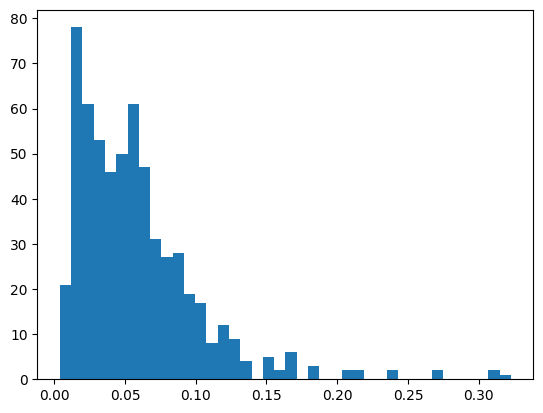

np.float64(0.04987849598378351)

In [18]:
# first, look at what percent the duration of an eclipse is of the system's period
percent_eclipse = pd.read_sql("""
select duration/period
from tom_binaryparameters
where duration = duration
;
""",
conn)

fig, ax = plt.subplots()
ax.hist(percent_eclipse["duration/period"], 40)
plt.show()

median_phase_percent = np.median(percent_eclipse["duration/period"])
median_phase_percent

Create a TargetList based on the targets in Table 1.
Next, break targets into categories depending on the fullness of their ephemeris data.
A given System/component ephemeris entry may be:
* Full: t0, period, and duration are present
* Partial: duration is missing but t0 and period are present
* Zero: no ephemeris data exists

Characterize each row of the ephemeris table.  
Then, for each QuadEB, collect the 4 categories (F, P, or Z) for its ephemerides.
Since there is system symmetry and component symmetry, sort these letters alphabetically.
Use this sorted 4 letter sequence as the label for that target.
Determine if a speckle observation captured a target during eclipse based on their 4-letter label.
  * Category F: Use the ephemeris data directly
  * Category P: Use the median phase percent calculated above in lieu of duration
  * Category Z: Assume system was not in eclipse


In [215]:
phase_event_defs = [
    ph.PhaseEventDef(
        "Not in Eclipse", partial(ph.calc_time_of_gress, ingress=False, synthetic_phase_percent=median_phase_percent)
    ),
    ph.PhaseEventDef("Eclipse", partial(ph.calc_time_of_gress, ingress=True, synthetic_phase_percent=median_phase_percent)),
]

creator = tlc.TargetListCreator(name="All Targets", connection=conn)
creator.steps = [
    tlc.add_targets,
    tlc.add_lists,
    partial(tlc.filter_targets, criteria=lambda df: df["List Table 1 Targets"]),
    partial(tlc.hide_cols, prefix="List "),
    partial(tlc.filter_targets, inverse=True, criteria=lambda df: df["Target Name"] == "TIC 168789840"),  # exclude Sextuple EB
    tlc.add_ephemerides,
    tlc.add_speckle,
    partial(tlc.add_speckle_phase, phase_event_defs=phase_event_defs),
    partial(tlc.add_side_status, phase_event_defs=phase_event_defs, side_state="Eclipse"),
]
tl = creator.calculate(verbose=False)
len(tl.target_list)

33

In [218]:
Time("2024-01-01", format="iso").jd

np.float64(2460310.5)

In [220]:
foo = tl.other_lists["Speckle Observations"]
len(foo[foo["Speckle Mid"] < 2460310])

50

In [ ]:
ephem = tl.other_lists["Ephemerides"]

# set category for each row of ephemerides table - these will be either M or P
ephem["Category"] = ["F" if duration == duration else "P" for duration in ephem["Duration"]]

# detect missing system/component combinations and create NaN rows for them with category M
blank_row_data = {column: float("NaN") for column in ephem.columns}
blank_row_data["Category"] = "Z"
for _, row in tl.target_list.iterrows():
    target_name = row["Target Name"]
    for system in ["A", "B"]:
        for member in ["a", "b"]:
            target_ephem = tl.other_lists["Ephemerides"].loc[target_name]
            ephemeris = target_ephem[(target_ephem["System"] == system) & (target_ephem["Member"] == member)]
            if len(ephemeris) == 0:
                new_row = blank_row_data.copy()
                new_row["System"] = system
                new_row["Member"] = member
                ephem = pd.concat([ephem, pd.DataFrame([new_row], index=pd.Index([target_name], name=ephem.index.name))])

# make new table listing target name and concatenated system/member categories
target_categories = ephem.reset_index().groupby("Target Name")["Category"].apply(lambda x: "".join(sorted(x))).to_frame(name="Category")

targets_by_category = {category: list(target_name) for category, target_name in target_categories.groupby("Category").groups.items()}

target_categories.pivot_table(index="Category", aggfunc="size")


33


Category
FFFF    16
FFPZ    12
FFZZ     1
PPPZ     3
PPZZ     1
dtype: int64

In [225]:
side = tl.other_lists["SIDE Observations"]
serrendipitous_eclipses = side.reset_index()[["Target Name", "UTC Mid", "System", "Member", "SIDE Type"]]
serrendipitous_eclipses.to_csv("Serendipitous Eclipses.csv", index=False)
speckle = tl.other_lists["Speckle Observations"]
speckle = speckle[speckle["Speckle Mid"] < 2460310.5]  # paper only includes speckle before 2024
print(f"{len(serrendipitous_eclipses)} eclipses out of {len(speckle)} observations")
serrendipitous_eclipses

23 eclipses out of 50 observations


,Target Name,UTC Mid,System,Member,SIDE Type
0,TIC 161043618,2022-05-11 08:39:00,A,b,Exact
1,TIC 161043618,2024-02-23 08:34:00,B,b,Exact
2,TIC 161043618,2024-02-23 08:55:00,B,b,Exact
3,TIC 283940788,2022-11-15 04:13:30,A,a,Exact
4,TIC 283940788,2022-09-28 08:25:00,A,b,Exact
5,TIC 283940788,2023-09-04 09:52:30,A,b,Exact
6,TIC 286470992,2022-09-28 11:19:30,B,a,Exact
7,TIC 317863971,2022-11-15 10:01:30,A,b,Exact
8,TIC 317863971,2023-03-08 04:08:00,B,a,Exact
9,TIC 336882813,2022-09-29 11:21:30,B,a,Exact


In [200]:
from glob import glob
observation_files = list(glob("../../astropaul/test/asd/DSSI Observations/*.csv"))
dssi_observations = pd.concat([pd.read_csv(file) for file in observation_files])


In [211]:

dssi_observations["TIC ID"] = [target_name if target_name.startswith("TIC") else "" for target_name in dssi_observations["Target Name"]]
len(dssi_observations[dssi_observations["TIC ID"] != ""])
len(dssi_observations[dssi_observations["Target Name"].str.startswith("H3")])

190